In [2]:
"""
Modern Portfolio Theory
Example with a 3-asset portfolio

"""

import numpy as np
from scipy.optimize import minimize
from functools import partial

import matplotlib.pyplot as plt


## Assets

Expected value $\boldsymbol{\mu}$ and covariance $\boldsymbol{\sigma}^2$ of expected returns of single assets are defined.

In [91]:
#> Three-asset portfolio
ptfs = {}

#> Two-asset portfolio
mu1, mu2 =  5., 10.
si1, si2 =  6., 15.
r12  = .0

mu = np.array([mu1, mu2])
si = np.array([
    [      si1**2, si1*si2*r12],
    [ si1*si2*r12,      si2**2]
])

ptfs['risky'] = { 'mu': mu, 'si': si, 'marker': 'x' }

#> Expected returns and covariance
mu1, mu2, mu3 = 5., 10.,  3.
si1, si2, si3 = 6., 15.,  0.
r12, r13, r23 = .0, .0, .0

mu = np.array([mu1, mu2, mu3])
si = np.array([
    [      si1**2, si1*si2*r12, si1*si3*r12],
    [ si1*si2*r12,      si2**2, si2*si3*r13],
    [ si1*si3*r13, si2*si3*r23,      si3**2]
])

ptfs['with risk-free'] = { 'mu': mu, 'si': si, 'marker': 's' }


## Modern Portfolio Theory

The evaluation of weights $\mathbf{w}$ of optimal asset allocation for MPT is recast as the optimization problem of *finding asset allocation with minimum volatility for the given expected return, under some constraints about asset allocation*

$$\begin{aligned}
  \mathbf{w}^* = \text{argmin}_{\mathbf{w}} \boldsymbol{\sigma}^2 \quad \text{ s.t.} \quad
  & \mathbf{w}^* \boldsymbol{\mu} = \overline{\boldsymbol  {\mu}} \\
  & \text{other constraints} \ ,
\end{aligned}$$

where other constraints could be:
- fully invested portfolio

   $$\sum_{k} w_k = 1 \ ,$$

- no leverage on asset $k$

   $$w_k \le 1 \ ,$$

- no short-selling on asset $k$

   $$w_k \ge 0 \ .$$

## Useful arrays and functions

In [92]:
# Find min, max returns for plots
mu_v = np.concatenate( [ i['mu'] for k,i in ptfs.items() ] )

min_mu = np.min(mu_v)
max_mu = np.max(mu_v)

#> MPT
# An optimization problem is solved for a set of desired return to find the efficient
# frontier of a portfolio, under the assumptions of MPT

#> Array of desired returns, between min and max return of single assets
des_ret_v = np.linspace(min_mu, max_mu, 30)

#> Constraints
def eq_desired_return(x, mu, desired_ret):
    return np.sum( x * mu ) - desired_ret

def eq_weight_sum(x):
    return np.sum(x) - 1

#> Objective function
def ptf_var(x, sigma):
    return x.T @ sigma @ x

## Efficient frontier and CAPM with possibility of leverage and short-selling




In [101]:
for kptf, ptf in ptfs.items():

    n_assets = len(ptf['mu'])

    ptf['wmat'] = []
    ptf['min_sig'] = []
    ptf['des_ret'] = np.linspace(np.min(ptf['mu']), np.max(ptf['mu']), 30)

    for desired_ret in ptf['des_ret']:

        #> Constraints (just comment if you don't want some)
        eq_cons = [
            {'type':   'eq', 'fun': partial(eq_desired_return, mu=ptf['mu'], desired_ret=desired_ret)},
            {'type':   'eq', 'fun': eq_weight_sum},     # sum(w) = 1 (fully invested)
        ]
        # eq_cons += [ {'type': 'ineq', 'fun': lambda x:   x[i]} for i in np.arange(n_assets) ]
        # eq_cons += [ {'type': 'ineq', 'fun': lambda x: 1-x[i]} for i in np.arange(n_assets) ]

        cost_fun = partial(ptf_var, sigma=ptf['si'])

        x0 = np.zeros(n_assets); x0[0] = 1  #  np.ones(3) / 3.
        res = minimize(cost_fun, x0, constraints=eq_cons,)

        # print(f"Desired Return: {desired_ret}, res: {res.x}")

        ptf_si = np.sqrt(res.x @ ptf['si'] @ res.x)
        ptf_mu = np.sum(res.x * ptf['mu'])

        #> Store weights and min variance, for the desired expected return
        ptf['wmat'] += [ res.x ]
        ptf['min_sig'] += [ ptf_si ]


### Plots

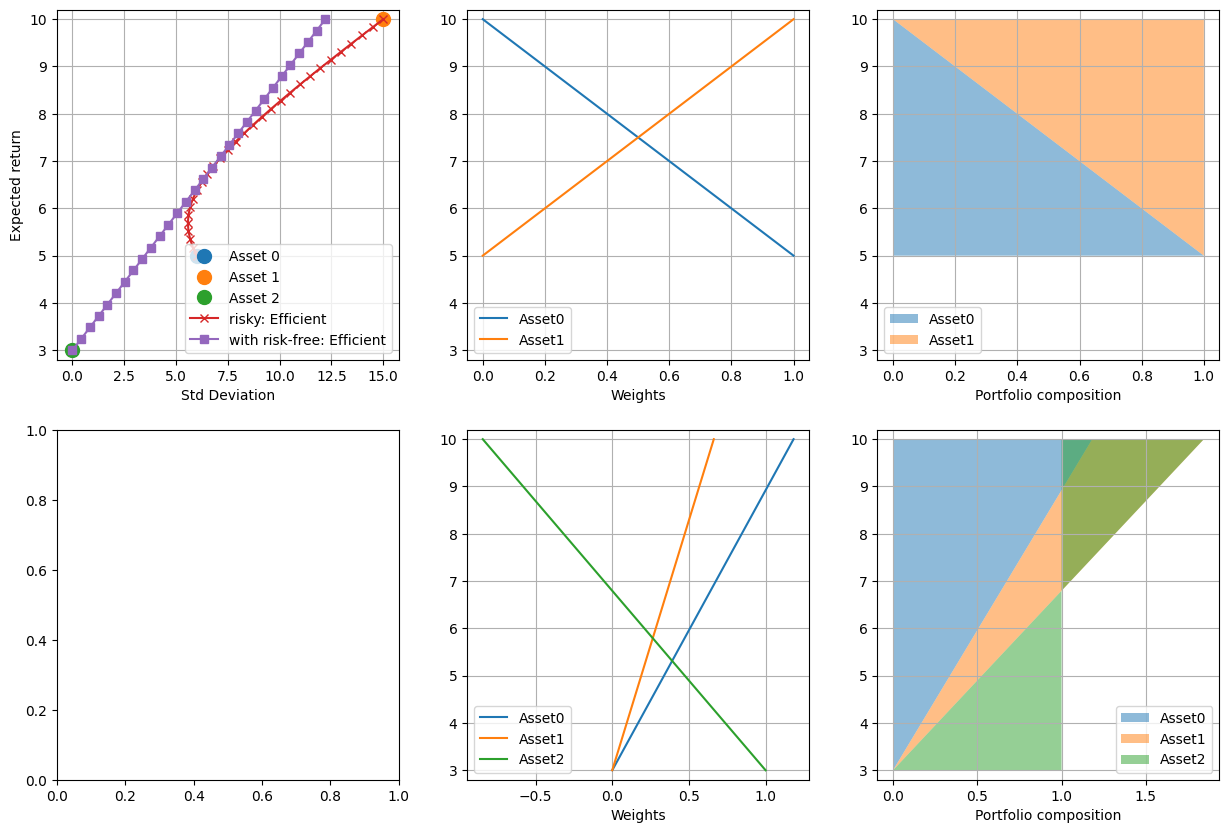

In [102]:
#> Initialize plot
fig, ax = plt.subplots(2, 3, figsize=(18, 12))

for iass in np.arange(len(mu)):
    ax[0,0].plot(si[iass,iass]**.5, mu[iass], 'o', markersize=10, label=f'Asset {iass}')

for kptf, ptf in ptfs.items():
    ax[0,0].plot(ptf['min_sig'], ptf['des_ret'], ptf['marker']+'-', label=kptf+': Efficient')

ax[0,0].set_ylim([min_mu-.2, max_mu+.2])
ax[0,0].set_xlabel("Std Deviation")
ax[0,0].set_ylabel("Expected return")
ax[0,0].grid()
ax[0,0].legend()

nptf = 0
for kptf, ptf in ptfs.items():

    #> Weights
    wmat = np.array(ptf['wmat'])

    for i in np.arange(np.shape(wmat)[1]):
        ax[nptf,1].plot(wmat[:,i], ptf['des_ret'], label=f"Asset{i}")

    ax[nptf,1].set_xlabel("Weights")
    ax[nptf,1].legend(); ax[nptf,1].grid()
    ax[nptf,1].set_ylim([min_mu-.2, max_mu+.2])

    #> Stacked - with expected return on y
    cum = np.zeros((np.shape(wmat)[0], np.shape(wmat)[1]+1))

    for i in np.arange(1, np.shape(cum)[1]):
        cum[:,i] = cum[:,i-1] + wmat[:,i-1]

    for i in np.arange(1, np.shape(cum)[1]):
        ax[nptf,2].fill_betweenx(ptf['des_ret'], cum[:,i-1], cum[:,i], label=f"Asset{i-1}", alpha = .5)

    ax[nptf,2].legend(); ax[nptf,2].grid()  # loc='upper right'
    ax[nptf,2].set_xlabel('Portfolio composition')
    ax[nptf,2].set_ylim([min_mu-.2, max_mu+.2])

    nptf += 1

plt.show()

## Efficient frontier and CAPM without leverage and short-selling


In [104]:
for kptf, ptf in ptfs.items():

    n_assets = len(ptf['mu'])

    ptf['wmat'] = []
    ptf['min_sig'] = []
    ptf['des_ret'] = np.linspace(np.min(ptf['mu']), np.max(ptf['mu']), 30)

    for desired_ret in ptf['des_ret']:

        #> Constraints (just comment if you don't want some)
        eq_cons = [
            {'type':   'eq', 'fun': partial(eq_desired_return, mu=ptf['mu'], desired_ret=desired_ret)},
            {'type':   'eq', 'fun': eq_weight_sum},     # sum(w) = 1 (fully invested)
        ]
        eq_cons += [ {'type': 'ineq', 'fun': lambda x:   x[i]} for i in np.arange(n_assets) ]
        eq_cons += [ {'type': 'ineq', 'fun': lambda x: 1-x[i]} for i in np.arange(n_assets) ]

        cost_fun = partial(ptf_var, sigma=ptf['si'])

        x0 = np.zeros(n_assets); x0[0] = 1  #  np.ones(3) / 3.
        res = minimize(cost_fun, x0, constraints=eq_cons,)

        # print(f"Desired Return: {desired_ret}, res: {res.x}")

        ptf_si = np.sqrt(res.x @ ptf['si'] @ res.x)
        ptf_mu = np.sum(res.x * ptf['mu'])

        #> Store weights and min variance, for the desired expected return
        ptf['wmat'] += [ res.x ]
        ptf['min_sig'] += [ ptf_si ]




### Plots

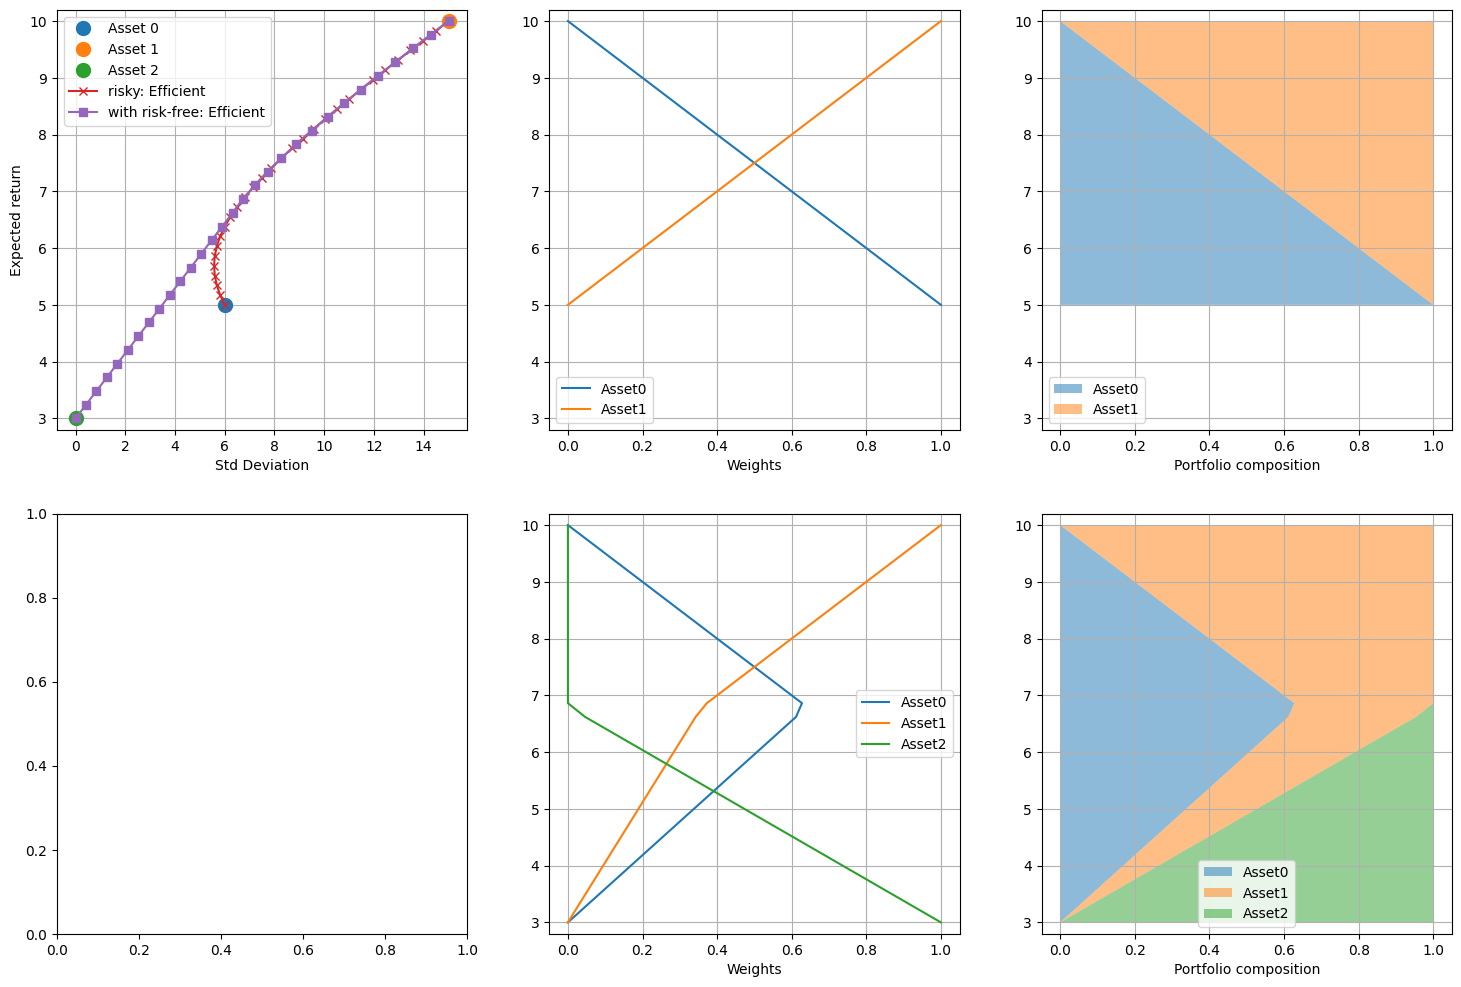

In [105]:
#> Initialize plot
fig, ax = plt.subplots(2, 3, figsize=(18, 12))

for iass in np.arange(len(mu)):
    ax[0,0].plot(si[iass,iass]**.5, mu[iass], 'o', markersize=10, label=f'Asset {iass}')

for kptf, ptf in ptfs.items():
    ax[0,0].plot(ptf['min_sig'], ptf['des_ret'], ptf['marker']+'-', label=kptf+': Efficient')

ax[0,0].set_ylim([min_mu-.2, max_mu+.2])
ax[0,0].set_xlabel("Std Deviation")
ax[0,0].set_ylabel("Expected return")
ax[0,0].grid()
ax[0,0].legend()

nptf = 0
for kptf, ptf in ptfs.items():

    #> Weights
    wmat = np.array(ptf['wmat'])

    for i in np.arange(np.shape(wmat)[1]):
        ax[nptf,1].plot(wmat[:,i], ptf['des_ret'], label=f"Asset{i}")

    ax[nptf,1].set_xlabel("Weights")
    ax[nptf,1].legend(); ax[nptf,1].grid()
    ax[nptf,1].set_ylim([min_mu-.2, max_mu+.2])

    #> Stacked - with expected return on y
    cum = np.zeros((np.shape(wmat)[0], np.shape(wmat)[1]+1))

    for i in np.arange(1, np.shape(cum)[1]):
        cum[:,i] = cum[:,i-1] + wmat[:,i-1]

    for i in np.arange(1, np.shape(cum)[1]):
        ax[nptf,2].fill_betweenx(ptf['des_ret'], cum[:,i-1], cum[:,i], label=f"Asset{i-1}", alpha = .5)

    ax[nptf,2].legend(); ax[nptf,2].grid()  # loc='upper right'
    ax[nptf,2].set_xlabel('Portfolio composition')
    ax[nptf,2].set_ylim([min_mu-.2, max_mu+.2])

    nptf += 1

plt.show()